In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pycocotools
from pycocotools import mask
import pycocotools.mask as mask_util
import numpy as np
import json
from pycocotools.coco import COCO
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl
from tqdm import tqdm

def np_encoder(object):
    if isinstance(object, np.generic):
        return object.item()

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from matplotlib.colors import ListedColormap

In [ ]:
import os

os.chdir('/content/drive/MyDrive/srikaran')
os.getcwd()

'/content/drive/MyDrive/srikaran'

In [ ]:
os.makedirs('/content/datasets')

In [ ]:
import zipfile
import os

zip_path = '/content/drive/My Drive/srikaran/uw-madison-gi-tract-image-segmentation.zip'
extract_path = '/content/datasets'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipped successfully!")

Unzipped successfully!


In [ ]:
!ls /content/datasets/train/case90/case90_day0/scans

slice_0001_266_266_1.50_1.50.png  slice_0073_266_266_1.50_1.50.png
slice_0002_266_266_1.50_1.50.png  slice_0074_266_266_1.50_1.50.png
slice_0003_266_266_1.50_1.50.png  slice_0075_266_266_1.50_1.50.png
slice_0004_266_266_1.50_1.50.png  slice_0076_266_266_1.50_1.50.png
slice_0005_266_266_1.50_1.50.png  slice_0077_266_266_1.50_1.50.png
slice_0006_266_266_1.50_1.50.png  slice_0078_266_266_1.50_1.50.png
slice_0007_266_266_1.50_1.50.png  slice_0079_266_266_1.50_1.50.png
slice_0008_266_266_1.50_1.50.png  slice_0080_266_266_1.50_1.50.png
slice_0009_266_266_1.50_1.50.png  slice_0081_266_266_1.50_1.50.png
slice_0010_266_266_1.50_1.50.png  slice_0082_266_266_1.50_1.50.png
slice_0011_266_266_1.50_1.50.png  slice_0083_266_266_1.50_1.50.png
slice_0012_266_266_1.50_1.50.png  slice_0084_266_266_1.50_1.50.png
slice_0013_266_266_1.50_1.50.png  slice_0085_266_266_1.50_1.50.png
slice_0014_266_266_1.50_1.50.png  slice_0086_266_266_1.50_1.50.png
slice_0015_266_266_1.50_1.50.png  slice_0087_266_266_1.50_1.50

In [ ]:
os.chdir('/content/drive/My Drive/srikaran/gi-tract-image-segmentation')
os.getcwd()

'/content/drive/My Drive/srikaran/gi-tract-image-segmentation'

In [ ]:
ls

config.py                     Large_UNET_model_epoch_5.pth  README.md
datasets/                     Large_UNET_model_epoch_6.pth  requirements.txt
DeepLab_model_epoch_0.pth     Large_UNET_model_epoch_7.pth  small_UNET_model_epoch_0.pth
DeepLab_model_epoch_1.pth     Large_UNET_model_epoch_8.pth  small_UNET_model_epoch_1.pth
DeepLab_model_epoch_2.pth     Large_UNET_model_epoch_9.pth  small_UNET_model_epoch_2.pth
DeepLab_model_epoch_3.pth     LICENSE                       small_UNET_model_epoch_3.pth
DeepLab_model_epoch_4.pth     notebooks/                    small_UNET_model_epoch_4.pth
DeepLab_model_epoch_5.pth     PE_UNET_model_epoch_0.pth     small_UNET_model_epoch_5.pth
DeepLab_model_epoch_6.pth     PE_UNET_model_epoch_1.pth     small_UNET_model_epoch_6.pth
DeepLab_model_epoch_7.pth     PE_UNET_model_epoch_2.pth     small_UNET_model_epoch_7.pth
DeepLab_model_epoch_8.pth     PE_UNET_model_epoch_3.pth     small_UNET_model_epoch_8.pth
DeepLab_model_epoch_9.pth     PE_UNET_model_epoch_4.

# Preprocess

In [ ]:
from src.data import SegmentationDataset
from src.data import DataGenerator

from src.loss import DiceLoss, ChannelwiseHausdorffDistanceLoss, CombinedLoss, IoU, AverageMeter
from src.utils.plot_utils import plot_masks, display_comparison

CLASSES = ['small_bowel', 'large_bowel', 'stomach']

In [ ]:
# Dice Loss
class DiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        y_pred = y_pred.contiguous().view(-1)
        y_true = y_true.contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dice = (2. * intersection + self.smooth) / (y_pred.sum() + y_true.sum() + self.smooth)
        return 1 - dice

def dice_coef_func(y_true, y_pred, smooth=1):
    y_true_f = y_true.contiguous().view(-1)
    y_pred_f = y_pred.contiguous().view(-1)
    intersection = torch.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + smooth)

In [ ]:
# Update json files to include the slice number, taken from filepath

import json

def extract_slice_number(file_name):
    # Extract the slice number from the file_name
    slice_number = file_name.split('/slice_')[1].split('_')[0]
    return int(slice_number)

def update_json_file(input_json_path, output_json_path):
    with open(input_json_path, 'r') as file:
        data = json.load(file)

    # Update each image entry with the slice number
    for image in data['images']:
        slice_number = extract_slice_number(image['file_name'])
        image['slice'] = slice_number

    # Write the updated JSON back to a new file
    with open(output_json_path, 'w') as file:
        json.dump(data, file, indent=4)

# Train
input_json_path = '/content/drive/My Drive/srikaran/gi-tract-image-segmentation/datasets/coco/train_json.json'
output_json_path = '/content/drive/My Drive/joe/coco/train_updated_json.json'
update_json_file(input_json_path, output_json_path)

# Validation
input_json_path = '/content/drive/My Drive/srikaran/gi-tract-image-segmentation/datasets/coco/val_json.json'
output_json_path = '/content/drive/My Drive/joe/coco/val_updated_json.json'
update_json_file(input_json_path, output_json_path)

# Test
input_json_path = '/content/drive/My Drive/srikaran/gi-tract-image-segmentation/datasets/coco/test_json.json'
output_json_path = '/content/drive/My Drive/joe/coco/test_updated_json.json'
update_json_file(input_json_path, output_json_path)


In [ ]:
# Check that "slice" is present
def print_first_entries(json_path, num_entries=2):
    with open(json_path, 'r') as file:
        data = json.load(file)
        images = data['images'][:num_entries]
        for image in images:
            print(json.dumps(image, indent=4))

print("--- Checking for Train ---")
json_path = '/content/drive/My Drive/joe/coco/train_updated_json.json'
print_first_entries(json_path)

print("--- Checking for Validation ---")
json_path = '/content/drive/My Drive/joe/coco/val_updated_json.json'
print_first_entries(json_path)

print("--- Checking for Test ---")
json_path = '/content/drive/My Drive/joe/coco/test_updated_json.json'
print_first_entries(json_path)



--- Checking for Train ---
{
    "id": 1,
    "file_name": "case129/case129_day20/scans/slice_0061_360_310_1.50_1.50.png",
    "width": 360,
    "height": 310,
    "slice": 61
}
{
    "id": 2,
    "file_name": "case34/case34_day16/scans/slice_0048_276_276_1.63_1.63.png",
    "width": 276,
    "height": 276,
    "slice": 48
}
--- Checking for Validation ---
{
    "id": 1,
    "file_name": "case44/case44_day19/scans/slice_0067_266_266_1.50_1.50.png",
    "width": 266,
    "height": 266,
    "slice": 67
}
{
    "id": 2,
    "file_name": "case54/case54_day30/scans/slice_0065_266_266_1.50_1.50.png",
    "width": 266,
    "height": 266,
    "slice": 65
}
--- Checking for Test ---
{
    "id": 1,
    "file_name": "case124/case124_day20/scans/slice_0080_266_266_1.50_1.50.png",
    "width": 266,
    "height": 266,
    "slice": 80
}
{
    "id": 2,
    "file_name": "case19/case19_day12/scans/slice_0073_360_310_1.50_1.50.png",
    "width": 360,
    "height": 310,
    "slice": 73
}


# Build Model

In [ ]:
import torch.nn as nn

class PositionPredictionModel(nn.Module):
    def __init__(self):
        super(PositionPredictionModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(64, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        self.regressor = nn.Linear(64, 1)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.regressor(x)
        return x

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.norm1 = nn.InstanceNorm2d(out_channels)
        self.relu1 = nn.LeakyReLU(0.1)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.norm2 = nn.InstanceNorm2d(out_channels)
        self.relu2 = nn.LeakyReLU(0.1)
        self._init_weights()

    def forward(self, x):
        x = self.relu1(self.norm1(self.conv1(x)))
        x = self.relu2(self.norm2(self.conv2(x)))
        return x

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = ConvBlock(in_channels, out_channels)
        self._init_weights()

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

    def _init_weights(self):
        # Initialize weights for the transpose convolution
        nn.init.kaiming_normal_(self.up.weight, mode='fan_out', nonlinearity='relu')
        if self.up.bias is not None:
            nn.init.constant_(self.up.bias, 0)

class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()
        self.inc = ConvBlock(3, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)

        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)

        self.outc = nn.Conv2d(64, 3, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

        self.position_model = PositionPredictionModel()

        self._init_weights()

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        # Segmentation output
        seg_output = self.sigmoid(self.outc(x))

        # Positional output
        pos_output = self.position_model(x1)

        return seg_output, pos_output

    def _init_weights(self):
        # Initialize weights for the final output convolution
        nn.init.kaiming_normal_(self.outc.weight, mode='fan_out', nonlinearity='relu')
        if self.outc.bias is not None:
            nn.init.constant_(self.outc.bias, 0)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
model = SimpleUNet()
input = torch.randn(1, 3, 128, 128)
seg_output, pos_output = model(input)
print(seg_output.shape)  # Should be torch.Size([1, 3, 128, 128])
print(pos_output.shape)

torch.Size([1, 3, 128, 128])
torch.Size([1, 1])


In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = SimpleUNet().to(device)

# Optimizer and Scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=5, verbose=True, min_lr=0.001)

# Loss function
criterion = DiceLoss().to(device)
iou_criterion = IoU().to(device)

# Training and validation loops
train_losses = []
train_iou_0 = [] # small bowel
train_iou_1 = [] # large bowel
train_iou_2 = [] # stomach

val_losses = []
val_iou_0 = []
val_iou_1 = []
val_iou_2 = []

train_seg_losses = []
train_pos_losses = []
val_seg_losses = []
val_pos_losses = []

train_dice_coefs = []
val_dice_coefs = []

epochs = 20

predictions_first = []
actuals_first = []


for epoch in range(epochs):
    model.train()
    seg_loss_fn = DiceLoss()
    pos_loss_fn = nn.MSELoss()
    train_loss_meter = AverageMeter()
    train_seg_loss_meter = AverageMeter()
    train_pos_loss_meter = AverageMeter()
    dice_coef_meter = AverageMeter()
    iou_meter_0 = AverageMeter()
    iou_meter_1 = AverageMeter()
    iou_meter_2 = AverageMeter()

    for data, true_masks, true_positions in tqdm(train_loader, desc=f'Epoch {epoch} Training'):
        data, true_masks, true_positions = data.to(device), true_masks.to(device), true_positions.to(device).float()
        data = data.permute(0, 3, 1, 2)
        true_masks = true_masks.permute(0, 3, 1, 2)

        optimizer.zero_grad()

        seg_output, pos_output = model(data)

        seg_loss = seg_loss_fn(seg_output, true_masks)
        pos_loss = pos_loss_fn(pos_output, true_positions)
        loss = seg_loss + pos_loss

        loss.backward()
        optimizer.step()

        train_seg_loss_meter.update(seg_loss.item(), data.size(0))
        train_pos_loss_meter.update(pos_loss.item(), data.size(0))
        train_loss_meter.update(loss.item(), data.size(0))
        dice_coef_meter.update(dice_coef_func(seg_output, true_masks).item(), data.size(0))
        iou_0, iou_1, iou_2 = iou_criterion(seg_output.cpu(), true_masks.cpu())
        iou_meter_0.update(iou_0.item(), data.size(0))
        iou_meter_1.update(iou_1.item(), data.size(0))
        iou_meter_2.update(iou_2.item(), data.size(0))

    train_seg_losses.append(train_seg_loss_meter.avg)
    train_pos_losses.append(train_pos_loss_meter.avg)
    train_losses.append(train_loss_meter.avg)
    train_dice_coefs.append(dice_coef_meter.avg)
    train_iou_0.append(iou_meter_0.avg)
    train_iou_1.append(iou_meter_1.avg)
    train_iou_2.append(iou_meter_2.avg)

    # Validation phase
    model.eval()
    val_loss_meter = AverageMeter()
    val_seg_loss_meter = AverageMeter()
    val_pos_loss_meter = AverageMeter()
    val_dice_coef_meter = AverageMeter()
    val_iou_meter_0 = AverageMeter()
    val_iou_meter_1 = AverageMeter()
    val_iou_meter_2 = AverageMeter()

    with torch.no_grad():
        for data, true_masks, true_positions in tqdm(val_loader, desc=f'Epoch {epoch} Validation'):
            data, true_masks, true_positions = data.to(device), true_masks.to(device), true_positions.to(device).float()
            data = data.permute(0, 3, 1, 2)
            true_masks = true_masks.permute(0, 3, 1, 2)
            seg_output, pos_output = model(data)

            seg_loss = seg_loss_fn(seg_output, true_masks)
            pos_loss = pos_loss_fn(pos_output, true_positions)
            loss = seg_loss + pos_loss

            val_seg_loss_meter.update(seg_loss.item(), data.size(0))
            val_pos_loss_meter.update(pos_loss.item(), data.size(0))
            val_loss_meter.update(loss.item(), data.size(0))
            val_dice_coef_meter.update(dice_coef_func(seg_output, true_masks).item(), data.size(0))
            iou_0, iou_1, iou_2 = iou_criterion(seg_output.cpu(), true_masks.cpu())
            val_iou_meter_0.update(iou_0.item(), data.size(0))
            val_iou_meter_1.update(iou_1.item(), data.size(0))
            val_iou_meter_2.update(iou_2.item(), data.size(0))

            # Collect predictions and actuals for visualization
            predictions_first.extend(pos_output.detach().cpu().numpy())
            actuals_first.extend(true_positions.detach().cpu().numpy())

    val_seg_losses.append(val_seg_loss_meter.avg)
    val_pos_losses.append(val_pos_loss_meter.avg)
    val_losses.append(val_loss_meter.avg)
    val_dice_coefs.append(val_dice_coef_meter.avg)

    val_losses.append(val_loss_meter.avg)
    val_iou_0.append(val_iou_meter_0.avg)
    val_iou_1.append(val_iou_meter_1.avg)
    val_iou_2.append(val_iou_meter_2.avg)

    scheduler.step(val_loss_meter.avg)
    print(f'Epoch {epoch}: Train Loss: {train_loss_meter.avg:.4f}, Val Loss: {val_loss_meter.avg:.4f}, \n \
            Train Seg Loss: {train_seg_loss_meter.avg:.4f}, Val Seg Loss: {val_seg_loss_meter.avg:.4f}, \n \
            Train Pos Loss: {train_pos_loss_meter.avg:.4f}, Val Pos Loss: {val_pos_loss_meter.avg:.4f}, \n \
            Train Dice: {dice_coef_meter.avg:.4f}, Val Dice: {val_dice_coef_meter.avg:.4f}, \n \
            Train IOU SB: {iou_meter_0.avg:.4f}, Val IOU SB: {val_iou_meter_0.avg:.4f}, \n \
            Train IOU LB: {iou_meter_1.avg:.4f}, Val IOU LB: {val_iou_meter_1.avg:.4f}, \n \
            Train IOU S: {iou_meter_2.avg:.4f}, Val IOU S: {val_iou_meter_2.avg:.4f}')

    # Save model checkpoint
    torch.save(model.state_dict(), f'PE_FM_UNET_model_epoch_{epoch}.pth')

Using device: cuda


Epoch 0 Validation: 100%|██████████| 145/145 [00:22<00:00,  6.39it/s]


Epoch 0: Train Loss: 701.6877, Val Loss: 459.1801, 
             Train Seg Loss: 0.4151, Val Seg Loss: 0.4309, 
             Train Pos Loss: 701.2726, Val Pos Loss: 458.7492, 
             Train Dice: 0.5849, Val Dice: 0.5691, 
             Train IOU SB: 0.1136, Val IOU SB: 0.1085, 
             Train IOU LB: 0.2432, Val IOU LB: 0.1922, 
             Train IOU S: 0.1699, Val IOU S: 0.1186


Epoch 1 Validation: 100%|██████████| 145/145 [00:22<00:00,  6.39it/s]


Epoch 1: Train Loss: 493.6676, Val Loss: 458.5256, 
             Train Seg Loss: 0.2101, Val Seg Loss: 0.3236, 
             Train Pos Loss: 493.4575, Val Pos Loss: 458.2019, 
             Train Dice: 0.7899, Val Dice: 0.6764, 
             Train IOU SB: 0.1687, Val IOU SB: 0.1199, 
             Train IOU LB: 0.3367, Val IOU LB: 0.2436, 
             Train IOU S: 0.2933, Val IOU S: 0.1842


Epoch 2 Validation: 100%|██████████| 145/145 [00:22<00:00,  6.41it/s]


Epoch 2: Train Loss: 493.5607, Val Loss: 458.4039, 
             Train Seg Loss: 0.1468, Val Seg Loss: 0.3188, 
             Train Pos Loss: 493.4139, Val Pos Loss: 458.0851, 
             Train Dice: 0.8532, Val Dice: 0.6812, 
             Train IOU SB: 0.2042, Val IOU SB: 0.1472, 
             Train IOU LB: 0.3811, Val IOU LB: 0.2382, 
             Train IOU S: 0.3610, Val IOU S: 0.2124


Epoch 3 Validation: 100%|██████████| 145/145 [00:22<00:00,  6.45it/s]


Epoch 3: Train Loss: 493.1073, Val Loss: 457.5475, 
             Train Seg Loss: 0.1105, Val Seg Loss: 0.2523, 
             Train Pos Loss: 492.9968, Val Pos Loss: 457.2952, 
             Train Dice: 0.8895, Val Dice: 0.7477, 
             Train IOU SB: 0.2246, Val IOU SB: 0.1342, 
             Train IOU LB: 0.4105, Val IOU LB: 0.2813, 
             Train IOU S: 0.4032, Val IOU S: 0.2749


Epoch 4 Validation: 100%|██████████| 145/145 [00:22<00:00,  6.44it/s]


Epoch 4: Train Loss: 492.4788, Val Loss: 457.1042, 
             Train Seg Loss: 0.0800, Val Seg Loss: 0.2284, 
             Train Pos Loss: 492.3988, Val Pos Loss: 456.8758, 
             Train Dice: 0.9200, Val Dice: 0.7716, 
             Train IOU SB: 0.2446, Val IOU SB: 0.1507, 
             Train IOU LB: 0.4356, Val IOU LB: 0.2876, 
             Train IOU S: 0.4500, Val IOU S: 0.2913


Epoch 5 Validation: 100%|██████████| 145/145 [00:22<00:00,  6.45it/s]


Epoch 5: Train Loss: 491.6739, Val Loss: 457.3015, 
             Train Seg Loss: 0.0624, Val Seg Loss: 0.2036, 
             Train Pos Loss: 491.6116, Val Pos Loss: 457.0980, 
             Train Dice: 0.9376, Val Dice: 0.7964, 
             Train IOU SB: 0.2606, Val IOU SB: 0.1681, 
             Train IOU LB: 0.4516, Val IOU LB: 0.3149, 
             Train IOU S: 0.4655, Val IOU S: 0.3457


Epoch 6 Validation: 100%|██████████| 145/145 [00:22<00:00,  6.46it/s]


Epoch 6: Train Loss: 491.3187, Val Loss: 457.5366, 
             Train Seg Loss: 0.0422, Val Seg Loss: 0.2150, 
             Train Pos Loss: 491.2765, Val Pos Loss: 457.3216, 
             Train Dice: 0.9578, Val Dice: 0.7850, 
             Train IOU SB: 0.2836, Val IOU SB: 0.1559, 
             Train IOU LB: 0.4729, Val IOU LB: 0.3053, 
             Train IOU S: 0.4921, Val IOU S: 0.3133


Epoch 7 Validation: 100%|██████████| 145/145 [00:22<00:00,  6.47it/s]


Epoch 7: Train Loss: 490.5886, Val Loss: 457.5571, 
             Train Seg Loss: 0.0346, Val Seg Loss: 0.2043, 
             Train Pos Loss: 490.5540, Val Pos Loss: 457.3528, 
             Train Dice: 0.9654, Val Dice: 0.7957, 
             Train IOU SB: 0.2883, Val IOU SB: 0.1766, 
             Train IOU LB: 0.4793, Val IOU LB: 0.3076, 
             Train IOU S: 0.5005, Val IOU S: 0.3473


Epoch 8 Validation: 100%|██████████| 145/145 [00:22<00:00,  6.47it/s]


Epoch 8: Train Loss: 490.0473, Val Loss: 456.7692, 
             Train Seg Loss: 0.0232, Val Seg Loss: 0.2227, 
             Train Pos Loss: 490.0241, Val Pos Loss: 456.5465, 
             Train Dice: 0.9768, Val Dice: 0.7773, 
             Train IOU SB: 0.3009, Val IOU SB: 0.2202, 
             Train IOU LB: 0.4923, Val IOU LB: 0.2978, 
             Train IOU S: 0.5150, Val IOU S: 0.3457


Epoch 9 Validation: 100%|██████████| 145/145 [00:22<00:00,  6.47it/s]


Epoch 9: Train Loss: 489.3171, Val Loss: 455.8193, 
             Train Seg Loss: 0.0111, Val Seg Loss: 0.2000, 
             Train Pos Loss: 489.3060, Val Pos Loss: 455.6193, 
             Train Dice: 0.9889, Val Dice: 0.8000, 
             Train IOU SB: 0.3114, Val IOU SB: 0.1767, 
             Train IOU LB: 0.5057, Val IOU LB: 0.3013, 
             Train IOU S: 0.5312, Val IOU S: 0.3599


Epoch 10 Validation: 100%|██████████| 145/145 [00:22<00:00,  6.48it/s]


Epoch 10: Train Loss: 488.7159, Val Loss: 454.7272, 
             Train Seg Loss: 0.0061, Val Seg Loss: 0.2046, 
             Train Pos Loss: 488.7098, Val Pos Loss: 454.5226, 
             Train Dice: 0.9939, Val Dice: 0.7954, 
             Train IOU SB: 0.3175, Val IOU SB: 0.2045, 
             Train IOU LB: 0.5118, Val IOU LB: 0.3131, 
             Train IOU S: 0.5366, Val IOU S: 0.3367


Epoch 11 Validation: 100%|██████████| 145/145 [00:22<00:00,  6.47it/s]


Epoch 11: Train Loss: 488.2261, Val Loss: 453.7567, 
             Train Seg Loss: 0.0006, Val Seg Loss: 0.1889, 
             Train Pos Loss: 488.2255, Val Pos Loss: 453.5679, 
             Train Dice: 0.9994, Val Dice: 0.8111, 
             Train IOU SB: 0.3256, Val IOU SB: 0.2151, 
             Train IOU LB: 0.5168, Val IOU LB: 0.3281, 
             Train IOU S: 0.5410, Val IOU S: 0.3681


Epoch 12 Validation: 100%|██████████| 145/145 [00:22<00:00,  6.48it/s]


Epoch 12: Train Loss: 487.8453, Val Loss: 452.7713, 
             Train Seg Loss: -0.0066, Val Seg Loss: 0.1966, 
             Train Pos Loss: 487.8520, Val Pos Loss: 452.5747, 
             Train Dice: 1.0066, Val Dice: 0.8034, 
             Train IOU SB: 0.3312, Val IOU SB: 0.1723, 
             Train IOU LB: 0.5252, Val IOU LB: 0.3113, 
             Train IOU S: 0.5544, Val IOU S: 0.3780


Epoch 13 Validation: 100%|██████████| 145/145 [00:22<00:00,  6.48it/s]


Epoch 13: Train Loss: 487.4336, Val Loss: 451.8794, 
             Train Seg Loss: -0.0102, Val Seg Loss: 0.1943, 
             Train Pos Loss: 487.4438, Val Pos Loss: 451.6850, 
             Train Dice: 1.0102, Val Dice: 0.8057, 
             Train IOU SB: 0.3358, Val IOU SB: 0.1850, 
             Train IOU LB: 0.5303, Val IOU LB: 0.3166, 
             Train IOU S: 0.5566, Val IOU S: 0.3612


Epoch 14 Validation: 100%|██████████| 145/145 [00:22<00:00,  6.42it/s]


Epoch 14: Train Loss: 487.2395, Val Loss: 451.0944, 
             Train Seg Loss: -0.0148, Val Seg Loss: 0.2133, 
             Train Pos Loss: 487.2543, Val Pos Loss: 450.8811, 
             Train Dice: 1.0148, Val Dice: 0.7867, 
             Train IOU SB: 0.3444, Val IOU SB: 0.2124, 
             Train IOU LB: 0.5357, Val IOU LB: 0.3010, 
             Train IOU S: 0.5573, Val IOU S: 0.3299


Epoch 15 Validation: 100%|██████████| 145/145 [00:22<00:00,  6.40it/s]


Epoch 15: Train Loss: 486.6451, Val Loss: 450.7615, 
             Train Seg Loss: -0.0181, Val Seg Loss: 0.2147, 
             Train Pos Loss: 486.6632, Val Pos Loss: 450.5468, 
             Train Dice: 1.0181, Val Dice: 0.7853, 
             Train IOU SB: 0.3449, Val IOU SB: 0.2013, 
             Train IOU LB: 0.5383, Val IOU LB: 0.3046, 
             Train IOU S: 0.5626, Val IOU S: 0.2984


Epoch 16 Validation: 100%|██████████| 145/145 [00:22<00:00,  6.46it/s]


Epoch 16: Train Loss: 486.4419, Val Loss: 450.5330, 
             Train Seg Loss: -0.0218, Val Seg Loss: 0.2053, 
             Train Pos Loss: 486.4638, Val Pos Loss: 450.3277, 
             Train Dice: 1.0218, Val Dice: 0.7947, 
             Train IOU SB: 0.3518, Val IOU SB: 0.1771, 
             Train IOU LB: 0.5429, Val IOU LB: 0.3040, 
             Train IOU S: 0.5737, Val IOU S: 0.3740


Epoch 17 Validation: 100%|██████████| 145/145 [00:22<00:00,  6.40it/s]


Epoch 17: Train Loss: 486.2620, Val Loss: 450.4717, 
             Train Seg Loss: -0.0244, Val Seg Loss: 0.2086, 
             Train Pos Loss: 486.2864, Val Pos Loss: 450.2631, 
             Train Dice: 1.0244, Val Dice: 0.7914, 
             Train IOU SB: 0.3523, Val IOU SB: 0.2308, 
             Train IOU LB: 0.5448, Val IOU LB: 0.3099, 
             Train IOU S: 0.5756, Val IOU S: 0.3607


Epoch 18 Validation: 100%|██████████| 145/145 [00:22<00:00,  6.48it/s]


Epoch 18: Train Loss: 486.1049, Val Loss: 450.6348, 
             Train Seg Loss: -0.0277, Val Seg Loss: 0.2178, 
             Train Pos Loss: 486.1326, Val Pos Loss: 450.4171, 
             Train Dice: 1.0277, Val Dice: 0.7822, 
             Train IOU SB: 0.3566, Val IOU SB: 0.1808, 
             Train IOU LB: 0.5471, Val IOU LB: 0.3179, 
             Train IOU S: 0.5854, Val IOU S: 0.3531


Epoch 19 Validation: 100%|██████████| 145/145 [00:22<00:00,  6.47it/s]


Epoch 19: Train Loss: 485.9617, Val Loss: 450.8980, 
             Train Seg Loss: -0.0310, Val Seg Loss: 0.2068, 
             Train Pos Loss: 485.9927, Val Pos Loss: 450.6912, 
             Train Dice: 1.0310, Val Dice: 0.7932, 
             Train IOU SB: 0.3587, Val IOU SB: 0.1805, 
             Train IOU LB: 0.5540, Val IOU LB: 0.3352, 
             Train IOU S: 0.5841, Val IOU S: 0.3660


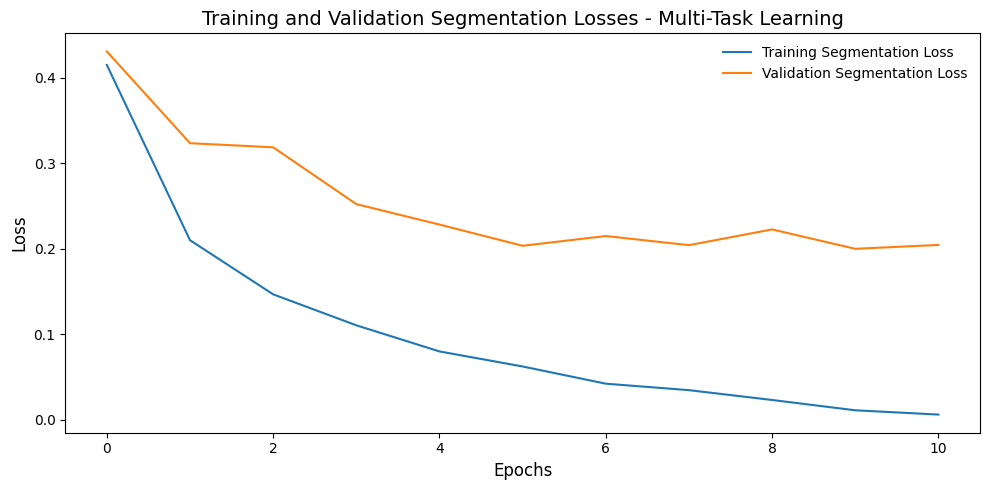

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_seg_losses[:11], label='Training Segmentation Loss')
plt.plot(val_seg_losses[:11], label='Validation Segmentation Loss')

# Add title and labels with specified font size
plt.title('Training and Validation Segmentation Losses - Multi-Task Learning', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)

# Adjust the legend
plt.legend(fontsize=10, frameon=False)

# Remove grid lines
plt.grid(False)

# Set the background color to white (or any other color)
plt.gca().set_facecolor('white')

# Set tight layout to ensure everything fits without overlap
plt.tight_layout()

plt.show()

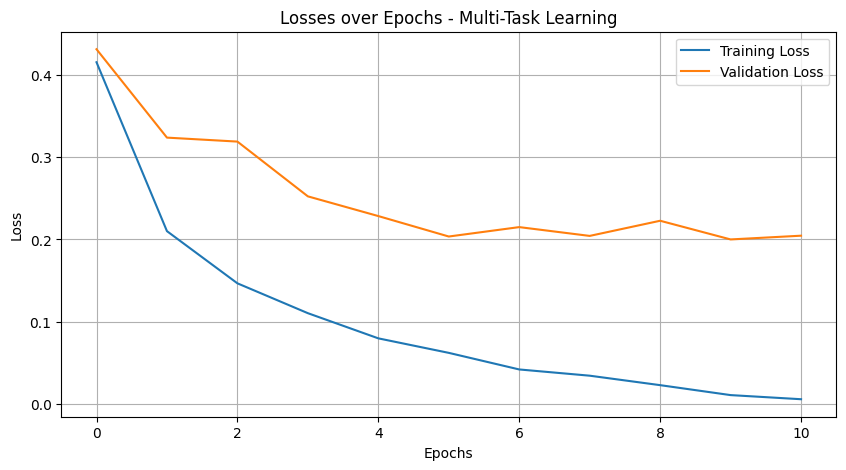

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_seg_losses[:11], label='Training Loss')
plt.plot(val_seg_losses[:11], label='Validation Loss')
plt.title('Losses over Epochs - Multi-Task Learning')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

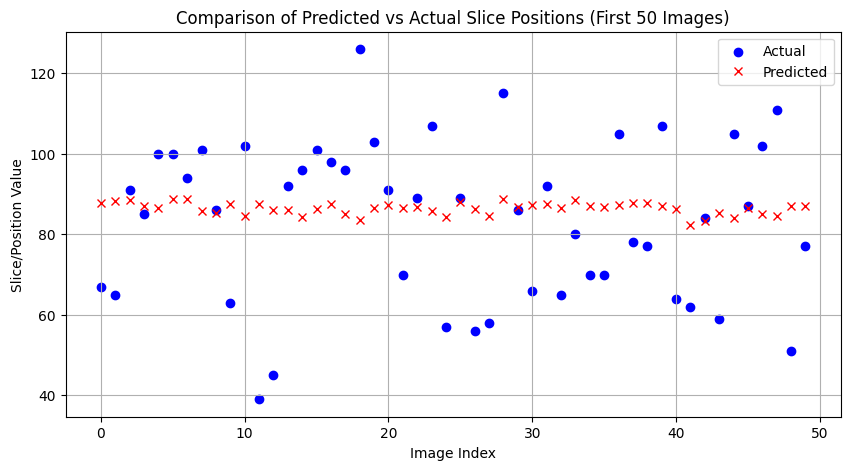

In [ ]:
import matplotlib.pyplot as plt

num_samples_to_display = min(50, len(actuals_first))
plt.figure(figsize=(10, 5))

# Replace the blue line with blue circles
plt.scatter(range(num_samples_to_display), actuals_first[:num_samples_to_display], color='blue', marker='o', label='Actual')
# Red "x" marker for the predicted values
plt.plot(range(num_samples_to_display), predictions_first[:num_samples_to_display], 'rx', label='Predicted')

plt.xlabel('Image Index')
plt.ylabel('Slice/Position Value')
plt.title('Comparison of Predicted vs Actual Slice Positions (First 50 Images)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Prepare test set
test_generator_class = DataGenerator(dataset_dir='/content/datasets/train',
                                     subset="train",
                                     classes=CLASSES,
                                     input_image_size=(128,128),
                                     annFile='/content/drive/My Drive/joe/coco/test_updated_json.json',
                                     shuffle=False)
test_loader = DataLoader(test_generator_class, batch_size=32, num_workers=0)

loading annotations into memory...
Done (t=0.56s)
creating index...
index created!


In [ ]:
model = SimpleUNet().to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=5, verbose=True, min_lr=0.001)

# Criterion
criterion = DiceLoss().to(device)
iou_criterion = IoU().to(device)

In [ ]:
model = SimpleUNet().to(device)

# Load the saved model weights
model.load_state_dict(torch.load('PE_FM_UNET_model_epoch_9.pth'))

# Set the model to evaluation mode if you are making predictions
model.eval()

SimpleUNet(
  (inc): ConvBlock(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu1): LeakyReLU(negative_slope=0.1)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu2): LeakyReLU(negative_slope=0.1)
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): ConvBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (relu1): LeakyReLU(negative_slope=0.1)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm2): InstanceNorm2d(128, eps=1e-05, m

In [ ]:
images_test = []
predictions = []
masks = []
slices = []

test_iou_meter_0 = AverageMeter()
test_iou_meter_1 = AverageMeter()
test_iou_meter_2 = AverageMeter()
test_dice_loss_meter = AverageMeter()
test_pos_loss_meter = AverageMeter()

# No need to track gradients here
with torch.no_grad():
    for data in test_loader:
        # Assuming your DataLoader returns a tuple of (images, labels)
        images = data[0]
        images = images.permute(0, 3, 1, 2).to(device)
        images_test.append(images)

        # Generate predictions
        seg_output, pos_output = model(images)
        predictions.append(seg_output)
        mask = data[1].permute(0, 3, 1, 2).to(device)
        masks.append(mask)

        dice_loss = criterion(seg_output, mask)
        iou_value0, iou_value1, iou_value2 = iou_criterion(seg_output.cpu(), mask.cpu())

        test_dice_loss_meter.update(dice_loss.item(), seg_output.size(0))
        test_iou_meter_0.update(iou_value0.item(), seg_output.size(0))
        test_iou_meter_1.update(iou_value1.item(), seg_output.size(0))
        test_iou_meter_2.update(iou_value2.item(), seg_output.size(0))

print(f'Test Dice Loss: {test_dice_loss_meter.avg:.4f}, \n \
        Test MSE: {test_pos_loss_meter.avg:.4f}, \n \
        IOU for SB: {test_iou_meter_0.avg: .4f}, \n \
        IOU for LB: {test_iou_meter_1.avg: .4f}, \n \
        IOU for S: {test_iou_meter_2.avg: .4f}')

Test Dice Loss: 0.1935, 
         Test MSE: 0.0000, 
         IOU for SB:  0.1797, 
         IOU for LB:  0.3141, 
         IOU for S:  0.3552


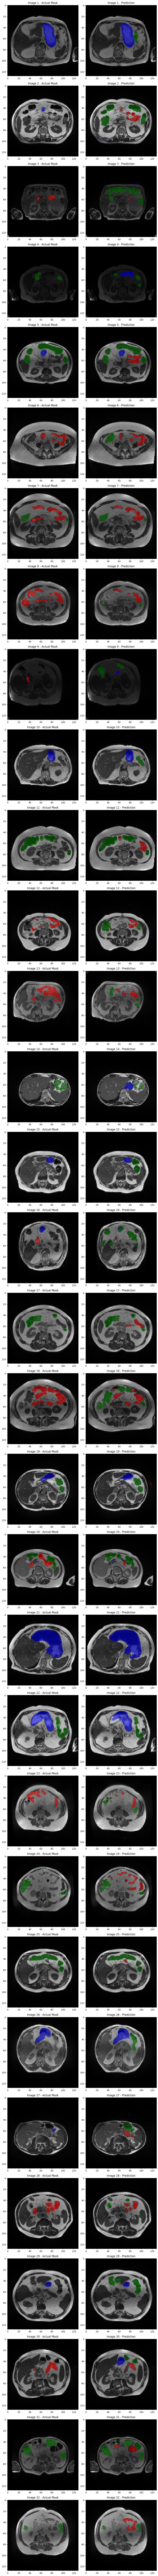

In [ ]:
img_s = images_test[81]
pred_s = predictions[81]
mask_s = masks[81]

display_comparison(img_s.cpu().numpy(), pred_s.cpu().numpy(), mask_s.cpu().numpy())

# Visualization for Paper

In [ ]:
import os
import pycocotools
from pycocotools import mask
import pycocotools.mask as mask_util
import numpy as np
import pandas as pd
import json
from pycocotools.coco import COCO
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl

def np_encoder(object):
    if isinstance(object, np.generic):
        return object.item()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.getcwd()

os.chdir('../')
os.chdir('/content/drive/My Drive/gi-tract-image-segmentation-2')

os.getcwd()

'/content/drive/My Drive/gi-tract-image-segmentation-2'

In [ ]:
from src_joe.data import SegmentationDataset
from src_joe.data import DataGenerator, DataLoader
from src_joe.model import SimpleUNet
from src_joe.loss import DiceLoss, ChannelwiseHausdorffDistanceLoss, CombinedLoss, IoU, AverageMeter
from src_joe.utils.plot_utils import plot_masks, display_comparison

CLASSES = ['small_bowel', 'large_bowel', 'stomach']

In [ ]:
viz_generator_class = DataGenerator(dataset_dir='/content/drive/My Drive/gi-tract-image-segmentation-2/datasets/train',
                                     subset="train",
                                     classes=CLASSES,
                                     input_image_size=(128,128),
                                     annFile='/content/drive/My Drive/gi-tract-image-segmentation-2/datasets/viz_json.json',
                                     shuffle=True)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
from src_joe.utils.plot_utils import plot_masks

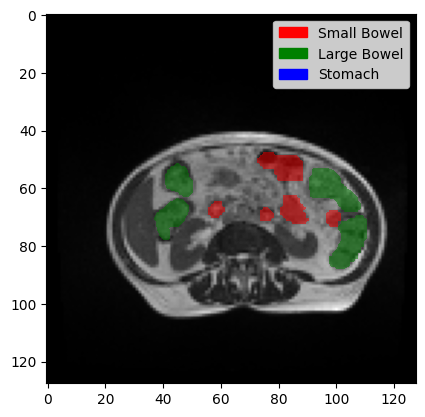

In [ ]:
from matplotlib.colors import ListedColormap

X, y = viz_generator_class.__getitem__(3)

plot_masks(X, y)

In [ ]:
viz_loader = DataLoader(viz_generator_class, batch_size=32, num_workers=0)
viz_loader

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
model = SimpleUNet()
input = torch.randn(1, 3, 128, 128)
output = model(input)
print(output.shape)  # Should be torch.Size([1, 3, 128, 128])

torch.Size([1, 3, 128, 128])


### Rerun the Model

In [ ]:
from src_joe.model import SimpleUNet
from src_joe.loss import DiceLoss
criterion = DiceLoss().to(device)

iou_criterion = IoU().to(device)

In [ ]:
model = SimpleUNet()
input = torch.randn(1, 3, 128, 128)
seg_output, pos_output = model(input)
print(seg_output.shape)  # Should be torch.Size([1, 3, 128, 128])
print(pos_output.shape)

torch.Size([1, 3, 128, 128])
torch.Size([1, 1])


In [ ]:
os.chdir('/content/drive/My Drive/srikaran/gi-tract-image-segmentation')

In [ ]:
model = SimpleUNet().to(device)

# Load the saved model weights
model.load_state_dict(torch.load('PE_FM_UNET_model_epoch_9.pth', map_location=torch.device('cpu')))

# Set the model to evaluation mode if you are making predictions
model.eval()

SimpleUNet(
  (inc): ConvBlock(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu1): LeakyReLU(negative_slope=0.1)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu2): LeakyReLU(negative_slope=0.1)
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): ConvBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (relu1): LeakyReLU(negative_slope=0.1)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm2): InstanceNorm2d(128, eps=1e-05, m

In [ ]:
from tqdm import tqdm

images_test = []
predictions = []
masks = []

test_iou_meter_0 = AverageMeter()
test_iou_meter_1 = AverageMeter()
test_iou_meter_2 = AverageMeter()
test_dice_loss_meter = AverageMeter()

# No need to track gradients here
with torch.no_grad():
    for data, target in tqdm(viz_loader):

        images = data.permute(0, 3, 1, 2).to(device)
        images_test.append(images)

        seg_output, pos_output = model(images)
        predictions.append(seg_output)
        mask = target.permute(0, 3, 1, 2).to(device)
        masks.append(mask)

print(f'Test Dice Loss: {test_dice_loss_meter.avg:.4f}, \n \
        IOU for SB: {test_iou_meter_0.avg: .4f}, \n \
        IOU for LB: {test_iou_meter_1.avg: .4f}, \n \
        IOU for S: {test_iou_meter_2.avg: .4f}')

100%|██████████| 1/1 [00:00<00:00, 25.36it/s]

Test Dice Loss: 0.0000, 
         IOU for SB:  0.0000, 
         IOU for LB:  0.0000, 
         IOU for S:  0.0000


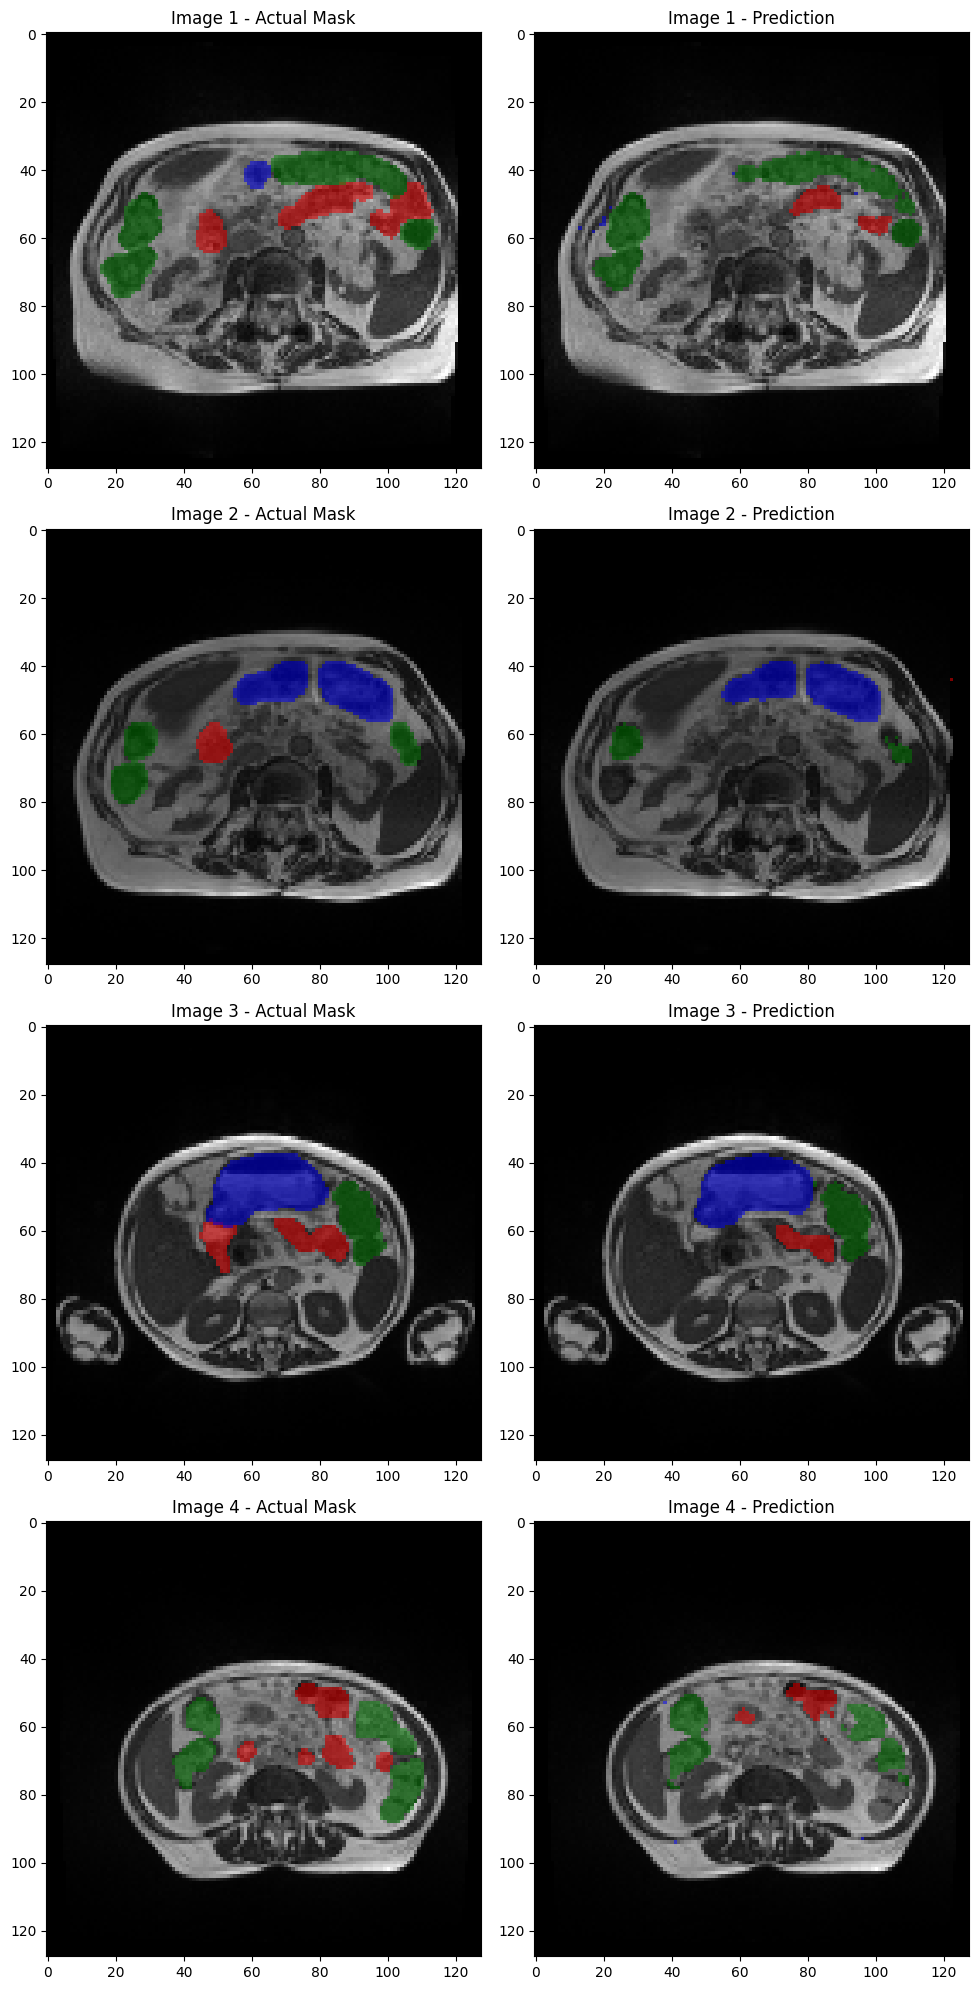

In [ ]:
img_s = images_test[0]
pred_sunet = predictions[0]
actual_masks = masks[0]

display_comparison(img_s.cpu().numpy(), pred_sunet.cpu().numpy(), actual_masks.cpu().numpy())